In [1]:
import datetime
import numpy as np
import pandas as pd
import mplfinance as mpf
import time
import matplotlib.pyplot as plt
import ccxt 
from sklearn.preprocessing import MinMaxScaler
import pprint

In [3]:

with open("a.txt") as f:
    lines = f.readlines()
    api_key = lines[0].strip()
    secret  = lines[1].strip()

binance = ccxt.binance(config={
    'apiKey': api_key, 
    'secret': secret,
    'enableRateLimit': True,
    'options': {
        'defaultType': 'future'
    }
})
binance.load_markets()
sym = 'BNB/USDT'
# sym = 'BTC/USDT'
def past_data(sym, tf, limit, since=None):
    coininfo = binance.fetch_ohlcv(
        symbol=sym, 
        timeframe=tf, 
#         since=since, 
        limit=limit
    )
    df = pd.DataFrame(coininfo, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    df.set_index('datetime', inplace=True)
    return df


In [19]:
balance = binance.fetch_balance()
positions = balance['info']['positions']

for position in positions:
#     print(position)
    if position["symbol"] == sym.replace("/", ""):
        print(position)
        pnl = float(position['unrealizedProfit'])/abs(float(position['positionAmt']))/float(position['entryPrice'])*100*float(position['leverage'])
        print(pnl)

{'symbol': 'BNBUSDT', 'initialMargin': '13.53331762', 'maintMargin': '1.01499877', 'unrealizedProfit': '2.34624569', 'positionInitialMargin': '13.53331762', 'openOrderInitialMargin': '0', 'leverage': '15', 'isolated': False, 'entryPrice': '236.0298850575', 'maxNotional': '250000', 'positionSide': 'BOTH', 'positionAmt': '-0.87', 'notional': '-202.99975430', 'isolatedWallet': '0', 'updateTime': '1686814415569', 'bidNotional': '0', 'askNotional': '0'}
17.138724567313567


In [54]:

def show_default_graph(m1, m2=None, m3=None, m4=None, n=100, title=''):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize = (12,6))

    n = len(m1)
#     mpf.plot(df,type='candle', volume=False, style='charles', ax=ax)
    xpoints = np.arange(len(m1))[-n:]

    if str(type(m1)) != "<class 'NoneType'>":
        ax.plot(xpoints, m1[-n:], color = (1, 0.7, 0), linewidth = 2, label='Close, 5-Day SMA')
    if str(type(m2)) != "<class 'NoneType'>":
        ax.plot(xpoints, m2[-n:], color = (1, 0.3, 0.3), linewidth = 1, label='Close, 20-Day SMA')
    if str(type(m3)) != "<class 'NoneType'>":
        ax.plot(xpoints, m3[-n:], color = (0.3, 0.3, 1), linewidth = 1, label='Close, 40-Day SMA')
    if str(type(m4)) != "<class 'NoneType'>":
        ax.plot(xpoints, m4[-n:], color = (0.6, 0.7, 1), linewidth = 1, label='Close, 40-Day SMA')

    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')

    ax.set_title(title)
    return ax

def show_transaction(transactions, m1=None, m2=None, m3=None, m4=None, n=100, title=''):
    n = len(m1)
    if n < 200:
        R = 2
    elif n < 500:
        R = 3
    else:
        R = 5
    ax = show_default_graph(m1, m2, m3, m4)
    for tr in transactions:
        color = 'b' if tr['position'] == 'Short' else 'r'
        ax.add_patch(plt.Arrow(
            tr['ent'][0], tr['ent'][1], 
            tr['close'][0]-tr['ent'][0], tr['close'][1]-tr['ent'][1],
            width = R, color=color, zorder=2, alpha=0.5
        ))
    return ax


def show_total_pnl(transactions):
    pnls=[]
    for tr in transactions:
        pnls.append(float(tr['pnl'][:-1]))
    total_pnl = np.sum(pnls)
#     print(f"{total_pnl} %")
    return total_pnl

def min_to_dhm(minute):
    running_d = minute//(60*24)
    running_h = (minute - (60*24)*running_d)//60
    running_m = minute - (60*24)*running_d - (60)*running_h
    return f"{running_d}D {running_h}H {running_m}m"

""" -----Rule-----
1. m2 ^ & m3 v & m4 /: 롱 진입
   m4 하락하기 시작: 롱 정리
2. m2 v & m3 ^ & m4 \: 숏 진입 
   m4 상승하기 시작: 숏 정리
3. 0.05% 이상 수익이 아니면 안팔기
4. 0.1% 이상 손실이면 팔기
"""

def timing2_close(status, m2, m3, m4, ref=0):
    i = -1
    m4_inc1 = m4[i-2] - m4[i-3] 
    m4_inc2 = m4[i] - m4[i-1] 
    if status == "Long": # n
        m4_turn = m4_inc1>ref and m4_inc2 <ref
    else:
        m4_turn = m4_inc1<ref and m4_inc2 >ref
    return m4_turn

def close(pos, tr, lev=1):
    p=1
    if pos == "Short":
        p = -1
    tr['position'] = pos
    profit = p*(tr['close'][1] - tr['ent'][1])/tr['ent'][1] # 1 means price
    profit = 100*profit - 0.08
    tr['pnl'] = str(round(lev*profit, 4))+"%"
    return tr

def get_best_ws(df, max2=20, max3=30, max4=50):
    best_pnl = 0
    best_tr = None
    ws = []
    for w2 in range(2,max2):
        for w3 in range(w2+1, max3):
            for w4 in range(w3+1, max4):
                transactions, total_pnl = simulate(df, w2, w3, w4)
                if total_pnl > best_pnl:
                    best_pnl = total_pnl
                    best_tr = (transactions, m1, m2, m3, m4)
                    ws.append([w2, w3, w4])
                    print(f"w2={w2}, w3={w3}, w4={w4} pnl:{total_pnl} %")
    return ws

def simulate(df, df_ts, w2, w3, w4, show_graph=False, just_one_tr=False):
    m1 = df['close'].rolling(window=1).mean()
    m2 = df['close'].rolling(window=w2).mean()
    m3 = df['close'].rolling(window=w3).mean()
    m4 = df['close'].rolling(window=w4).mean()
    m1_t2= df_ts[0]['close'].rolling(window=1).mean()
    m1_t3= df_ts[1]['close'].rolling(window=1).mean()
    m1_t4= df_ts[2]['close'].rolling(window=1).mean()
    m1_ts = [m1_t2, m1_t3, m1_t4]
    i, transactions = simul(m1, m2, m3, m4, m1_ts, just_one_tr=just_one_tr)
    if show_graph:
        show_transaction(transactions, m1, m2, m3, m4)
    total_pnl = show_total_pnl(transactions)
    if just_one_tr:
        return i, transactions, total_pnl
    return transactions, total_pnl
    
    
def whether_turnning(m2, m3, m4, ref=0.001*0.01, ref2=0.02*0.01):
    i = -1
    curr_m2on3 = (m2[i] - m3[i])/m2[i] > ref
    curr_m4 = np.abs((m4[i] - m4[i-2])/m4[i])
    pre_m4 = np.abs((m4[i-2] - m4[i-4])/m4[i-2])
    p_m2on3 = []
    p_m2under3 = []
    m4incs = []
    m4decs = []
    for pre in range(1, 10):
        m2on3 = (m2[i-pre] - m3[i-pre])/m2[i-pre] > ref
        m2under3 = (m2[i-pre] - m3[i-pre])/m2[i-pre] < -ref
        m4inc = (m4[i] - m4[i-pre])/m4[i] > 0
        m4dec = (m4[i] - m4[i-pre])/m4[i] < 0
        p_m2on3.append(m2on3)
        p_m2under3.append(m2under3)
        m4incs.append(m4inc)
        m4decs.append(m4dec)

    p_m2on3 = np.all(p_m2on3)
    p_m2under3 = np.all(p_m2under3)
    m4_increasing = np.all(m4incs)
    m4_decreasing = np.all(m4decs)
    
    m23_start_inc = p_m2under3 and curr_m2on3 
    m23_start_dec = p_m2on3 and not curr_m2on3
            
    if curr_m4 <pre_m4 and curr_m4 < ref2:
        if m23_start_inc and m4_decreasing:
            return 'u'
        elif m23_start_dec and m4_increasing:
            return 'n'
    return None

def minmax(m):
    m = (m - m.min())/(m.max() - m.min())
    return m

def get_curr_cond(m):
    mm = minmax(m)
    m_mean = np.mean(mm)
    return mm[-1] - m_mean
    
def get_curr_conds(sym, ms):
    pos_val = []
    for m in ms:
        v = get_curr_cond(m)
        pos_val.append(v)
#         show_default_graph(m)
    return pos_val

# tfs = ['3m', '15m', '1h', '6h']
# get_curr_conds(sym, tfs)


def simul(m1_, m2_, m3_, m4_, m_ts, just_one_tr=False):
    status = None
    transactions = []
    tr = {}
    curr_pnl = 0
    ent_i = 0
    
    ref =0.001*0.01
    for i in range(2, len(m1_)):
        m1, m2, m3, m4 = m1_[:i], m2_[:i], m3_[:i], m4_[:i]
        m1_t2, m1_t3, m1_t4 = m_ts[0][:i], m_ts[1][:i], m_ts[2][:i]
        if not m4[i-1] >0:
            continue
            
        if not status:
            
            turnning_shape = whether_turnning(m2, m3, m4, ref=0.001*0.01, ref2=0.01*0.01)  # u or n or None
#             val = get_curr_cond(m1)
            val = get_curr_conds(sym, [m1, m1_t2, m1_t3, m1_t4])
            
            if turnning_shape == 'u' and val[0] < -0.2 and np.mean(val[1:]) < 0.1:
                status = "Long"
            elif turnning_shape == 'n' and val[0] > 0.2 and np.mean(val[1:]) > 0.01:
                status = 'Short'

            if status:
                print(f">>>>>>>>>>>>>>>>{i} {status} entry price: {m1[-1]},  val:{val}")
                tr['ent'] = [i, m1[-1]]
                ent_price = m1[-1]
                ent_i = i
        else :
            p = 2*(-0.5+int(status=="Long"))
            curr_pnl = p*(m1[-1] - ent_price)/ent_price*100
            if curr_pnl < -1 or\
            (
                curr_pnl > 0.3 and\
                timing2_close(status, m2, m3, m4)
            ):
#                 print(curr_pnl, status)
                tr['close'] = [i, m1[-1]]
                tr = close(status, tr)
                transactions.append(tr)
                tr = {}
                status = None
                if just_one_tr:
                    return i, transactions
    print(curr_pnl, "%")
    return 0, transactions

In [55]:
# TODO: 
#     평균도 봐야함
#     이거 옮기기
#     급락하면 long 팔기
#     급등하면 short 팔기

TF  1m
test unit: 1D 1H 0m
total:  1D 1H 0m
--------------------[0 ~ 1500]
>>>>>>>>>>>>>>>>1025 Long entry price: 235.55,  val:[-0.35593959848300316, 0.3365355816521135, 0.28802959493895086, -0.6595842961881869]
[0 [11, 20, 40]] PNL:0.34%
>>>>>>>>>>>>>>>>164 Long entry price: 233.43,  val:[-0.21998360319737537, -0.27392299785066876, -0.47005600037025064, 0.16917711812777014]
[1151 [11, 20, 40]] PNL:0.348%
0 %
[1483 [11, 20, 40]] PNL:0.0%
0.6887 %

TF  3m
test unit: 3D 3H 0m
total:  3D 3H 0m
--------------------[0 ~ 1500]
>>>>>>>>>>>>>>>>1041 Short entry price: 246.12,  val:[0.29877294307863284, 0.29877294307863284, 0.44104268804493063, -0.6068786209595318]
[0 [11, 20, 40]] PNL:3.772%
0 %
[1177 [11, 20, 40]] PNL:0.0%
3.7718 %

TF  5m
test unit: 5D 5H 0m
total:  5D 5H 0m
--------------------[0 ~ 1500]
0 %
[0 [11, 20, 40]] PNL:0.0%
0.0 %

TF  15m
test unit: 15D 15H 0m
total:  15D 15H 0m
--------------------[0 ~ 1500]
0 %
[0 [11, 20, 40]] PNL:0.0%
0.0 %



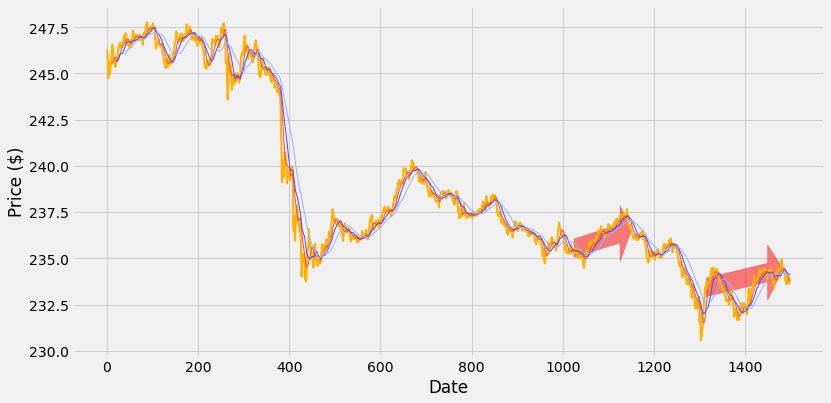

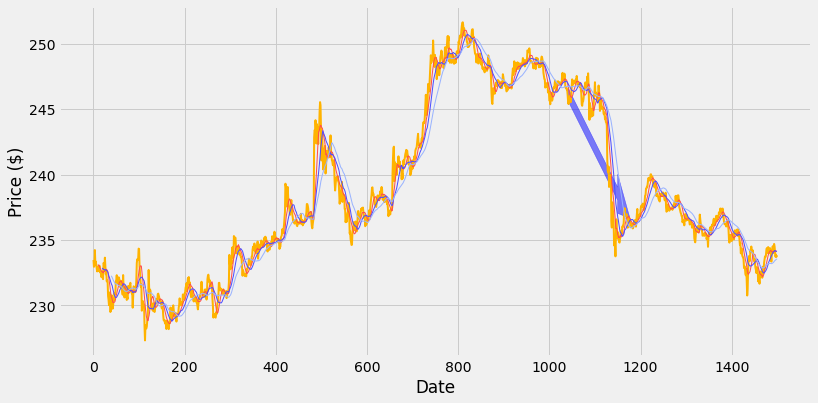

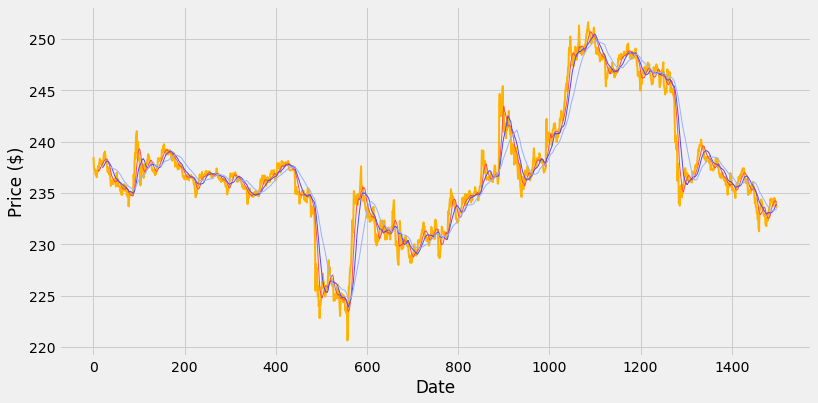

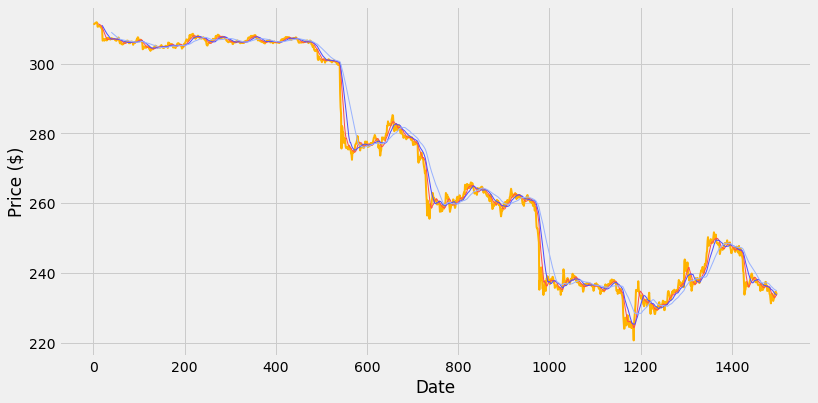

In [56]:
tfs = ['1m', '3m', '5m', '15m']
for tf in tfs:
    print("TF ", tf)
# tf = '1m'
    minute = int(tf[:-1])
    raw_df = past_data(sym, tf, limit=10000)
    df = raw_df
    # 1500 tf 몇등분 할거야
    df_t2 = past_data(sym, tfs[1], limit=10000)
    df_t3 = past_data(sym, tfs[2], limit=10000)
    df_t4 = past_data(sym, tfs[3], limit=10000)
#     df_ts = [df_t2, df_t3, df_t4]
    testnum = 1
    # 1500/testnum 의 시간은 얼마야
    total_m = len(df)*minute  # 1500
    test_m = int(total_m/testnum)  # 500
    print(f'test unit: '+min_to_dhm(test_m))
    print('total: ', min_to_dhm(total_m))

    # 첫번째 블럭 예측 ws
    unit = int(len(df)/testnum)
    PNL = []
    ws = [[11, 20, 40]]
    for idx in range(0, len(df), unit):
        idx2 = idx+unit
        print(f"{'-'*20}[{idx} ~ {idx2}]")
        test_df = df[idx:idx2]
        if idx < 0:  ## 예측값 생성
            pass
        else:
            wws = ws[-1]
            i = 0
            trs = []
            while i < len(test_df):
                df_ts = [df_t2[idx:idx2][i:], df_t3[idx:idx2][i:], df_t4[idx:idx2][i:]]
                i2, transactions, total_pnl = simulate(test_df[i:], df_ts, *wws, just_one_tr=True)
                print(f"[{idx+i} {wws}] PNL:{round(total_pnl, 3)}%")
                PNL.append(total_pnl)
                for tr in transactions:
                    tr['ent'][0] += idx+i
                    tr['close'][0] += idx+i

                trs += transactions
    #             wws = get_best_ws(df[:idx+i])[-1]
    #             print(f"df[~{idx+i}] {wws}")
                if i2 == 0:
                    break
                i += i2
            w2, w3, w4 = wws 
            m1 = df['close'].rolling(window=1).mean()
            m2 = df['close'].rolling(window=w2).mean()
            m3 = df['close'].rolling(window=w3).mean()
            m4 = df['close'].rolling(window=w4).mean()
            show_transaction(trs, m1, m2, m3, m4)

    print(np.sum(PNL), '%\n')

test unit: 1D 1H 0m
total:  1D 1H 0m
--------------------[0 ~ 1500]
>>>>>>>>>>>>>>>>141 Long entry price: 1753.22
[0 [11, 20, 40]] PNL:-0.349%
>>>>>>>>>>>>>>>>100 Long entry price: 1745.89
[158 [11, 20, 40]] PNL:0.31%
>>>>>>>>>>>>>>>>583 Short entry price: 1767.8
[332 [11, 20, 40]] PNL:0.64%
>>>>>>>>>>>>>>>>79 Long entry price: 1749.03
[1044 [11, 20, 40]] PNL:-0.336%
>>>>>>>>>>>>>>>>232 Short entry price: 1736.19
[1131 [11, 20, 40]] PNL:-0.335%
0 %
[1370 [11, 20, 40]] PNL:0.0%
-0.07100000000000012 %


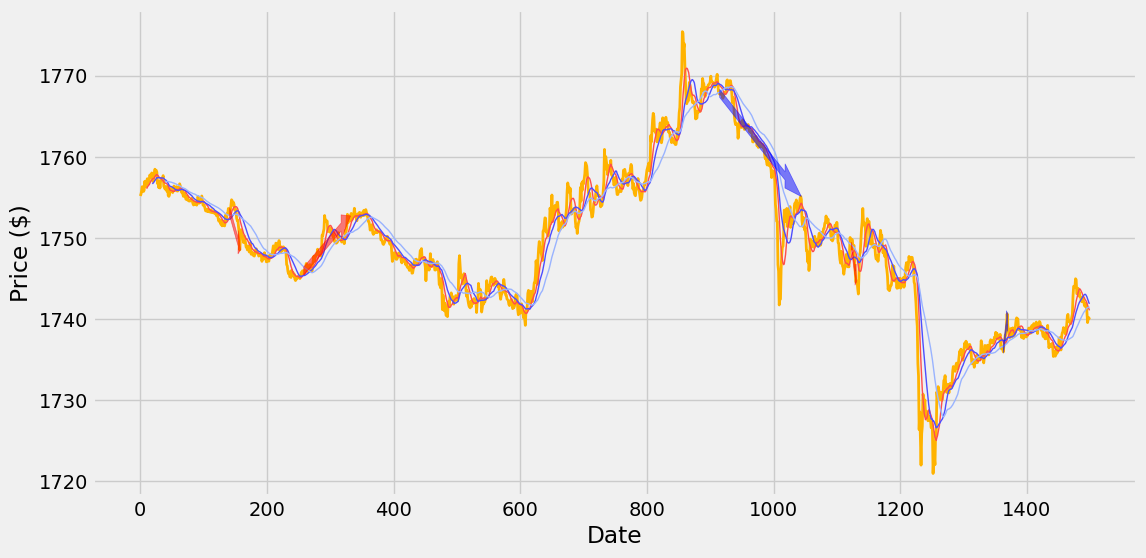

In [262]:

tf = '1m'
minute = int(tf[:-1])
raw_df = past_data(sym, tf, limit=10000)
df = raw_df
# 1500 tf 몇등분 할거야
testnum = 2
# 1500/testnum 의 시간은 얼마야
total_m = len(df)*minute  # 1500
test_m = int(total_m/testnum)  # 500
print(f'test unit: '+min_to_dhm(test_m))
print('total: ', min_to_dhm(total_m))

# 첫번째 블럭 예측 ws
unit = int(len(df)/testnum)
PNL = []
ws = [[11, 20, 40]]
for idx in range(0, len(df), unit):
    idx2 = idx+unit
    print(f"{'-'*20}[{idx} ~ {idx2}]")
    test_df = df[idx:idx2]
    if idx < 1:  ## 예측값 생성
        pass
    else:
        wws = ws[-1]
        i = 0
        trs = []
        while i < len(test_df):
            i2, transactions, total_pnl = simulate(test_df[i:], *wws, just_one_tr=True)
            print(f"[{idx+i} {wws}] PNL:{round(total_pnl, 3)}%")
            PNL.append(total_pnl)
            for tr in transactions:
                tr['ent'][0] += idx+i
                tr['close'][0] += idx+i
                
            trs += transactions
#             wws = get_best_ws(df[:idx+i])[-1]
#             print(f"df[~{idx+i}] {wws}")
            if i2 == 0:
                break
            i += i2
        w2, w3, w4 = wws 
        m1 = df['close'].rolling(window=1).mean()
        m2 = df['close'].rolling(window=w2).mean()
        m3 = df['close'].rolling(window=w3).mean()
        m4 = df['close'].rolling(window=w4).mean()
        show_transaction(trs, m1, m2, m3, m4)

print(np.sum(PNL), '%')

In [24]:
################################################################################

test unit: 7D 19H 30m
total:  15D 15H 0m
--------------------[0 ~ 750]
>>19 Long entry price: 1817.5
[0 [2, 11, 17]] PNL:-0.386%
>>18 Short entry price: 1813.01
[66 [2, 11, 17]] PNL:0.12%
>>27 Long entry price: 1801.79
[103 [2, 11, 17]] PNL:0.628%
>>19 Short entry price: 1813.63
[169 [2, 11, 17]] PNL:-0.536%
>>26 Short entry price: 1815.45
[193 [2, 11, 17]] PNL:-0.972%
>>21 Short entry price: 1855.81
[221 [2, 11, 17]] PNL:0.289%
>>26 Short entry price: 1852.56
[287 [2, 11, 17]] PNL:1.875%
>>22 Long entry price: 1794.14
[360 [2, 11, 17]] PNL:-0.464%
>>37 Long entry price: 1779.92
[385 [2, 11, 17]] PNL:0.813%
>>19 Short entry price: 1806.49
[473 [2, 11, 17]] PNL:-0.588%
>>17 Long entry price: 1813.46
[535 [2, 11, 17]] PNL:0.941%
>>24 Long entry price: 1827.1
[581 [2, 11, 17]] PNL:0.15%
>>19 Long entry price: 1825.82
[628 [2, 11, 17]] PNL:0.028%
>>20 Long entry price: 1823.57
[650 [2, 11, 17]] PNL:1.227%
>>22 Long entry price: 1845.02
-0.19837183336766442 %
[717 [2, 11, 17]] PNL:0.0%
----

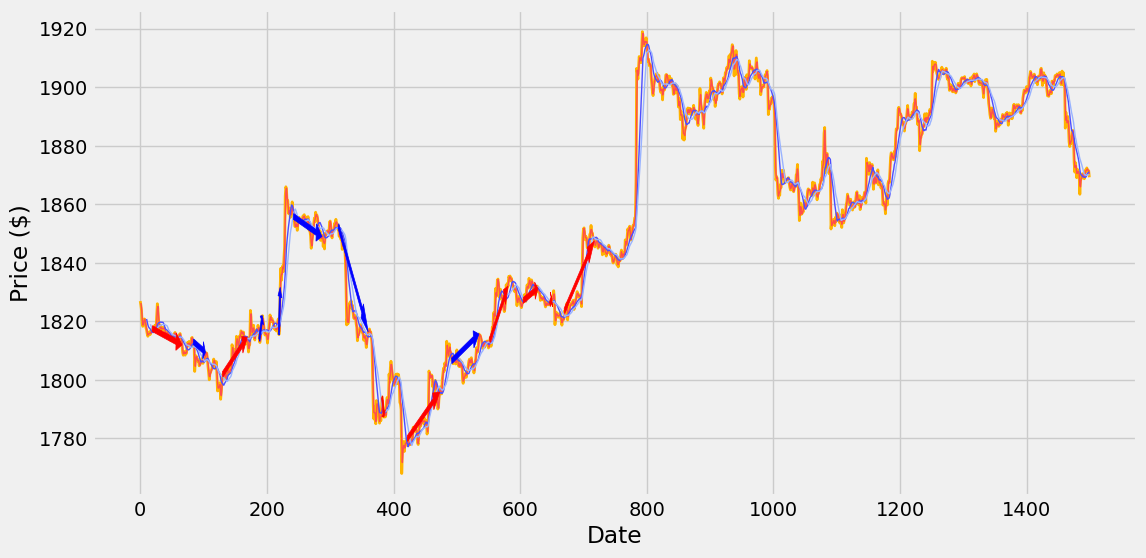

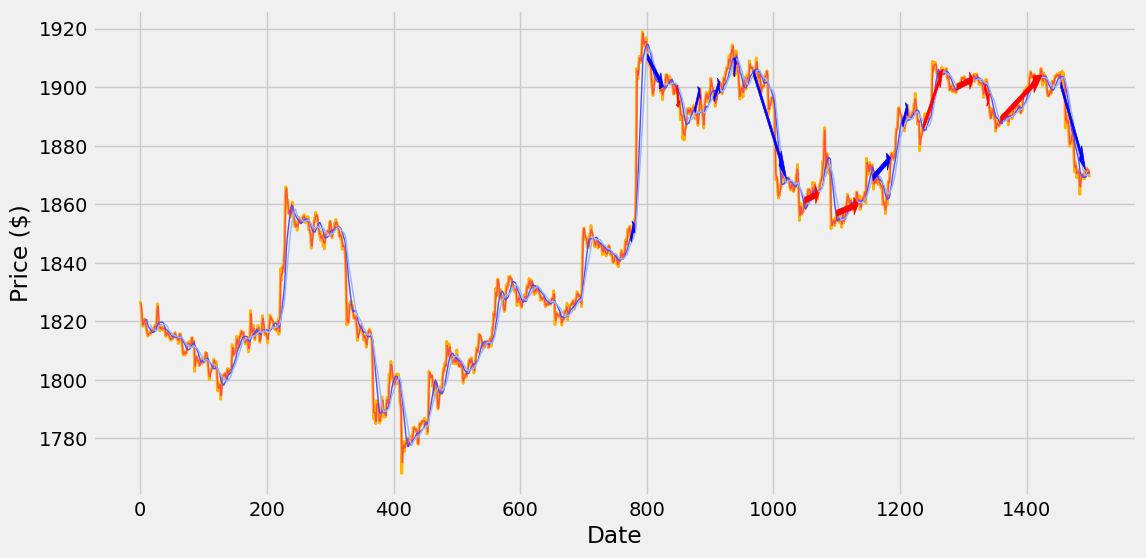

In [73]:

tf = '15m'
minute = int(tf[:-1])
raw_df = past_data(sym, tf, limit=10000)
df = raw_df
# 1500 tf 몇등분 할거야
testnum = 2
# 1500/testnum 의 시간은 얼마야
total_m = len(df)*minute  # 1500
test_m = int(total_m/testnum)  # 500
print(f'test unit: '+min_to_dhm(test_m))
print('total: ', min_to_dhm(total_m))

# 첫번째 블럭 예측 ws
unit = int(len(df)/testnum)
PNL = []
ws = [[2, 11, 17]]
for idx in range(0, len(df), unit):
    idx2 = idx+unit
    print(f"{'-'*20}[{idx} ~ {idx2}]")
    test_df = df[idx:idx2]
    if idx == -1:  ## 예측값 생성
#         ws = get_best_ws(test_df)[-1]
        ws = [[2, 11, 17]]
#         ws = [[2*minute, 11*minute, 17*minute]]
    else:
        wws = ws[-1]
        i = 0
        trs = []
        while i < len(test_df):
            i2, transactions, total_pnl = simulate(test_df[i:], *wws, just_one_tr=True)
            print(f"[{idx+i} {wws}] PNL:{round(total_pnl, 3)}%")
            PNL.append(total_pnl)
            for tr in transactions:
                tr['ent'][0] += idx+i
                tr['close'][0] += idx+i
                
            trs += transactions
#             wws = get_best_ws(df[:idx+i])[-1]
#             print(f"df[~{idx+i}] {wws}")
            if i2 == 0:
                break
            i += i2
        w2, w3, w4 = wws 
        m1 = df['close'].rolling(window=1).mean()
        m2 = df['close'].rolling(window=w2).mean()
        m3 = df['close'].rolling(window=w3).mean()
        m4 = df['close'].rolling(window=w4).mean()
        show_transaction(trs, m1, m2, m3, m4)

print(np.sum(PNL), '%')